# Build dataset for training ML-based models and analyze the effectiveness of the selected models

In [1]:
import pickle
import pandas as pd
import json
import re
import matplotlib.pyplot as plt

from ast import literal_eval

## 1. Build dataset

In [2]:
df_workflow_rerun = pd.read_csv('../data/dataframes/dataframe_workflow_rerun_distinct.csv.gz', index_col=0,converters={'reruns ids':literal_eval,'rerun conclusion':literal_eval,'content':literal_eval,'event':literal_eval})
data_records = df_workflow_rerun[['repo path','workflow file path','reruns ids','content','rerun conclusion','branch','default','event']].to_dict('records')

In [3]:
df_workflow_rerun

,File index,repo path,workflow file path,branch,default,event,reruns,reruns ids,# avg rerun,# max rerun,# min rerun,# rerun sets,last rerun's conclusion,# success,# failure,content,rerun conclusion
0,"[3, 3, 1]",1c-syntax/bsl-language-server,.github/workflows/qa.yml,develop,True,"[[workflow_run, workflow_run, workflow_run], [...","[2, 19, 7, 3, 3, 5, 6, 8, 2, 9, 1, 1]","[[6174675977, 6174737838, 6174898363], [644200...",5.500000,19,1,12,"['success', 'success', 'success', 'success', '...",7,5,[[https://api.github.com/repos/1c-syntax/bsl-l...,"[[failure, success, success], [failure, failur..."
1,"[3, 14, 0]",1c-syntax/bsl-language-server,.github/workflows/gradle.yml,feature/osClassModuleType,False,"[[push, pull_request]]",[1],"[[5694924874, 5694924932]]",1.000000,1,1,1,['failure'],0,1,[[https://api.github.com/repos/1c-syntax/bsl-l...,"[[failure, failure]]"
2,"[4, 1, 0]",1c-syntax/sonar-bsl-plugin-community,.github/workflows/night_build.yml,develop,True,"[[schedule, schedule, schedule], [schedule, sc...","[2, 3, 7, 6, 3, 2, 4, 18, 1, 13, 1]","[[3827335175, 3835710330, 3844383153], [385315...",5.454545,18,1,11,"['failure', 'failure', 'failure', 'failure', '...",0,11,[[https://api.github.com/repos/1c-syntax/sonar...,"[[failure, failure, failure], [failure, failur..."
3,"[8, 2, 0]",3arthqu4ke/3arthh4ck,.github/workflows/docker.yml,main,True,"[[workflow_run, workflow_run]]",[1],"[[4076411830, 4091899320]]",1.000000,1,1,1,['success'],1,0,[[https://api.github.com/repos/3arthqu4ke/3art...,"[[failure, success]]"
4,"[12, 11, 1]",94fzb/zrlog,.github/workflows/codeql-analysis.yml,master,True,"[[schedule, schedule, schedule, schedule, sche...","[8, 2, 3, 3]","[[3872519179, 3929066488, 3985101351, 40424906...",4.000000,8,2,4,"['success', 'success', 'success', 'success']",4,0,[[https://api.github.com/repos/94fzb/zrlog/con...,"[[failure, success, success, failure, success,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1367,"[3308, 4, 0]",zhouhailin/freeswitch-externals,dynamic/pages/pages-build-deployment,v1.7-dev,True,"[[dynamic, dynamic, dynamic]]",[2],"[[5123044637, 5123054258, 6582462821]]",2.000000,2,2,1,['success'],1,0,[[https://api.github.com/repos/zhouhailin/free...,"[[failure, success, success]]"
1368,"[3310, 2, 1]",zinggAI/zingg,.github/workflows/codeql.yml,0.3.5,False,"[[push, push]]",[1],"[[4581579825, 4626574290]]",1.000000,1,1,1,['failure'],0,1,[[https://api.github.com/repos/zinggAI/zingg/c...,"[[failure, failure]]"
1369,"[3310, 10, 1]",zinggAI/zingg,.github/workflows/codeql.yml,main,True,"[[push, schedule], [push, push], [push, schedu...","[1, 1, 1, 7, 2, 1, 2, 2, 3, 3, 4, 3, 8, 4]","[[4375112804, 4381093887], [4550952813, 455098...",3.000000,8,1,14,"['failure', 'failure', 'failure', 'failure', '...",0,14,[[https://api.github.com/repos/zinggAI/zingg/c...,"[[failure, failure], [failure, failure], [fail..."
1370,"[3314, 29, 0]",zonkyio/embedded-database-spring-test,.github/workflows/test.yml,flyway-9.9-plus,False,"[[push, pull_request]]",[1],"[[7534009017, 7534061061]]",1.000000,1,1,1,['failure'],0,1,[[https://api.github.com/repos/zonkyio/embedde...,"[[failure, failure]]"


In [4]:
# build dataset for ML-based models.

data_ml = []

for index,record in enumerate(data_records):
    
    for set_n in range(len(record['reruns ids'])):
        
        # verify if there's only 'success' and 'failure' in current rerun set. If not, skip the set.
        set_conclusion = list(set(record['rerun conclusion'][set_n]))
        
        verified = False
        
        if len(set_conclusion) == 2 and 'success' in set_conclusion and 'failure' in set_conclusion:
            
            verified = True
        
        if len(set_conclusion) == 1 and ('success' in set_conclusion or 'failure' in set_conclusion):
            
            verified = True
            
        if verified == True:
            
            for run_n in range(len(record['reruns ids'][set_n])):

                dict_record = {}
                
                dict_record['idx'] = index # The index represent the location(repository, wf file) of a single record.
                dict_record['reruns ids'] = record['reruns ids'][set_n][run_n]
                dict_record['conclusion'] = record['rerun conclusion'][set_n][run_n]
                dict_record['content'] = record['content'][set_n][run_n]
                dict_record['rerun_number'] = run_n
                dict_record['default'] = record['default']
                dict_record['event'] = record['event'][set_n][run_n]

                current_id = record['reruns ids'][set_n][run_n]

                if run_n == 0:

                    dict_record['last_rerun_conclusion'] = 0 # --> there's no previous rerun, current one is the first run

                elif record['rerun conclusion'][set_n][run_n-1] == 'success':

                    dict_record['last_rerun_conclusion'] = 1 # --> previous rerun's conclusion is 'success'

                else:

                    dict_record['last_rerun_conclusion'] = 2 # --> previous rerun's conclusion is 'failure'

                data_ml.append(dict_record)
                
                
# tokenize event data

event_id = {}
num_event = 0

for record in data_ml:
    if record['event'] not in event_id:
        event_id[record['event']] = num_event 
        num_event += 1 
    
for record in data_ml:
    record['event'] = event_id[record['event']]
    
print(f'Successfully loaded {len(data_ml)} data points, {num_event} types of event found')

Successfully loaded 50631 data points, 18 types of event found


In [5]:
data_ml[0]

{'idx': 0,
 'reruns ids': 6174675977,
 'conclusion': 'failure',
 'content': 'https://api.github.com/repos/1c-syntax/bsl-language-server/contents/.github/workflows/qa.yml?ref=ad6eb2ec4bfa516013765b518da57fbe380abf86',
 'rerun_number': 0,
 'default': True,
 'event': 0,
 'last_rerun_conclusion': 0}

In [6]:
# load the stored contents:
with open(f'content_json.pkl','rb') as f:
    content_json_list = pickle.load(f)

len(content_json_list)

6391

In [7]:
content_json_list[0]

{'name': 'ci-pr-reports.yml',
 'path': '.github/workflows/ci-pr-reports.yml',
 'sha': '4d2c38bb2b792d618f408d724d4e5024b458c476',
 'size': 2621,
 'url': 'https://api.github.com/repos/netty/netty/contents/.github/workflows/ci-pr-reports.yml?ref=5db037beedca8aa5b6a486fa515cc6af013ced74',
 'html_url': 'https://github.com/netty/netty/blob/5db037beedca8aa5b6a486fa515cc6af013ced74/.github/workflows/ci-pr-reports.yml',
 'git_url': 'https://api.github.com/repos/netty/netty/git/blobs/4d2c38bb2b792d618f408d724d4e5024b458c476',
 'download_url': 'https://raw.githubusercontent.com/netty/netty/5db037beedca8aa5b6a486fa515cc6af013ced74/.github/workflows/ci-pr-reports.yml',
 'type': 'file',
 'content': 'IyAtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0t\nLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tCiMgQ29weXJpZ2h0\nIDIwMjEgVGhlIE5ldHR5IFByb2plY3QKIwojIFRoZSBOZXR0eSBQcm9qZWN0\nIGxpY2Vuc2VzIHRoaXMgZmlsZSB0byB5b3UgdW5kZXIgdGhlIEFwYWNoZSBM\naWNlbnNlLAojIHZlcnNpb24gMi4wICh0aGUgIkxpY2Vuc2UiKTsgeW91

In [8]:
import yaml

def count_lines(text):
    # Split the text and count the number of lines
    lines = text.split('\n')
    num_lines = len(lines)
    return num_lines

def count_jobs(content):
    try:
        workflow_data = yaml.safe_load(content)
        
        if workflow_data != None and 'jobs' in workflow_data:
            num_jobs = len(workflow_data['jobs'])
        else:
            num_jobs = 0
    
    except Exception as e:
        num_jobs = 0
    
    return num_jobs

In [9]:
# decode the content into original workflow files.
import base64

content_decoded = []

for content in content_json_list:
    if 'content' in content:
        c_decoded = base64.b64decode(content['content']).decode('utf-8')
        content_decoded.append([c_decoded,count_jobs(c_decoded)])
    else:
        content_decoded.append(['',0])

In [10]:
content_list = []
for record in content_json_list:
    try:
        content_list.append(record['url'])
        
    except Exception:
        
        content_list.append('')
        
# created a dictionary with key:value = content_url:content_decoded
dict_url_content = {}
for i in range(len(content_list)):
    dict_url_content[content_list[i]] = content_decoded[i]

# update content feature and add 2 extra features n_lines & n_jobs
for record in data_ml:
    
    if record['content'] in dict_url_content:
        content_de = dict_url_content[record['content']]
        record['content'] = content_de[0]
        record['n_lines'] = count_lines(record['content'])
        record['n_jobs'] = content_de[1]
    
    else:
        record['content'] = ''
        record['n_lines'] = 0
        record['n_jobs'] = 0
    

## 2. Binary classification with 3 ML-based models - MLP, NB, DT. (using implementation from scikit-learn)

In [11]:
import numpy as np
import random

X = []
y = []

for record in data_ml:
    
    X.append(np.array([record['idx'],record['last_rerun_conclusion'],record['rerun_number'],record['n_lines'],record['n_jobs'],record['event'],record['default']]))
    y.append(1 if record['conclusion'] == 'success' else 0)

X = np.array(X)
y = np.array(y)

print(f'{len(y)} records in total')
print(f"{sum(y)} records with conclusion 'success', {len(y)-sum(y)} with 'failure', {round(sum(y)/len(y)*100,2)}% are positive")

50631 records in total
23462 records with conclusion 'success', 27169 with 'failure', 46.34% are positive


In [12]:
# Data spliting, ratio 8:2

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 1)
print(f"{len(y_train)} records in train set, {len(y_test)} in test set.")

40504 records in train set, 10127 in test set.


### 2.1 Baselines
#### 2.1.1 Baseline no.1: Random Prediction

In [13]:
class random_guess():
    
    def predict(self, inputs):
        predictions = []
        
        for record in inputs:
            predictions.append(random.choice([0,1]))
        
        return np.array(predictions)
    
    
rg = random_guess()
y_trues = y_test
y_preds_rg = rg.predict(X_test)

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

print(f"F1-score with Random Prediction model: {round(f1_score(y_trues, y_preds_rg), 3)}")
print(f"Precision with Random Prediction model: {round(precision_score(y_trues, y_preds_rg), 3)}")
print(f"Recall with Random Prediction model: {round(recall_score(y_trues, y_preds_rg), 3)}")

F1-score with Random Prediction model: 0.479
Precision with Random Prediction model: 0.463
Recall with Random Prediction model: 0.496


#### 2.1.2 Baseline no.2: Straw-Man Model

In [14]:
import random

class strawman():
    
    def predict(self, inputs):
        predictions = []
        
        for record in inputs:
            if record[1] == 1:
                predictions.append(1)
            elif record[1] == 2:
                predictions.append(0)
            else:
                predictions.append(random.choice([0,1]))
        
        return np.array(predictions)

st = strawman()
y_trues = y_test
y_preds_st = st.predict(X_test)


from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

print(f"F1-score with Straw-Man model: {round(f1_score(y_trues, y_preds_st), 3)}")
print(f"Precision with Straw-Man model: {round(precision_score(y_trues, y_preds_st), 3)}")
print(f"Recall with Straw-Man model: {round(recall_score(y_trues, y_preds_st), 3)}")

F1-score with Straw-Man model: 0.831
Precision with Straw-Man model: 0.813
Recall with Straw-Man model: 0.849


### 2.2 ML-based models:
#### 2.2.1 MLP classifier:

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
from sklearn.neural_network import MLPClassifier

mlp_all = MLPClassifier(hidden_layer_sizes=(50,100,50),early_stopping=True, validation_fraction=0.2, random_state=1, batch_size=16, max_iter=300).fit(X_train[:,1:], y_train)    # --> all features
mlp_his = MLPClassifier(hidden_layer_sizes=(50,100,50),early_stopping=True, validation_fraction=0.2, random_state=1, batch_size=16, max_iter=300).fit(X_train[:,[1,2]], y_train) # --> historical features
mlp_com = MLPClassifier(hidden_layer_sizes=(50,100,50),early_stopping=True, validation_fraction=0.2, random_state=1, batch_size=16, max_iter=300).fit(X_train[:,[3,4]], y_train) # --> complexity features 
mlp_chu = MLPClassifier(hidden_layer_sizes=(50,100,50),early_stopping=True, validation_fraction=0.2, random_state=1, batch_size=16, max_iter=300).fit(X_train[:,[5,6]], y_train) # --> churn features 

#mlp_his_1 = MLPClassifier(random_state=1, max_iter=300).fit(X_train[:,[1]], y_train)
#mlp_his_2 = MLPClassifier(random_state=1, max_iter=300).fit(X_train[:,[6]], y_train)

logits_all = mlp_all.predict_proba(X_test[:,1:])
logits_his = mlp_his.predict_proba(X_test[:,[1,2]])
logits_com = mlp_com.predict_proba(X_test[:,[3,4]])
logits_chu = mlp_chu.predict_proba(X_test[:,[5,6]])

#logits_his_1 = mlp_his_1.predict_proba(X_test[:,[1]])
#logits_his_2 = mlp_his_2.predict_proba(X_test[:,[6]])

In [17]:
# This function returns the greatest f1-score with the best threshold selected.
def best_f1(y_trues, logits):

    best_threshold=0
    best_f1=0
    
    for i in range(1,100):
        threshold=i/100
        y_preds=logits[:,1]>threshold
        f1=f1_score(y_trues, y_preds) 
        if f1>best_f1:
            best_f1=f1
            best_threshold=threshold

    y_preds=logits[:,1]>best_threshold

    f1=f1_score(y_trues, y_preds)
    
    return f1, y_preds

In [18]:
f1_all,y_preds_all=best_f1(y_trues, logits_all)
f1_his,y_preds_his=best_f1(y_trues, logits_his)
f1_com,y_preds_com=best_f1(y_trues, logits_com)
f1_chu,y_preds_chu=best_f1(y_trues, logits_chu)

In [19]:
print('**** F1_score ****')
print(round(f1_all,3))
print(round(f1_his,3))
print(round(f1_com,3))
print(round(f1_chu,3))
print('**** Precision ****')
print(round(precision_score(y_trues, y_preds_all),3))
print(round(precision_score(y_trues, y_preds_his),3))
print(round(precision_score(y_trues, y_preds_com),3))
print(round(precision_score(y_trues, y_preds_chu),3))
print('**** Recall ****')
print(round(recall_score(y_trues, y_preds_all),3))
print(round(recall_score(y_trues, y_preds_his),3))
print(round(recall_score(y_trues, y_preds_com),3))
print(round(recall_score(y_trues, y_preds_chu),3))

**** F1_score ****
0.9
0.887
0.715
0.666
**** Precision ****
0.906
0.928
0.608
0.501
**** Recall ****
0.894
0.85
0.869
0.994


#### 2.2.2 Naive-Bayes

In [20]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB().fit(X_train[:,1:], y_train)
logits_gnb = gnb.predict_proba(X_test[:,1:])

f1_gnb,y_preds_gnb=best_f1(y_trues, logits_gnb)

print(f"F1-score with Naive-Bayes: {round(f1_score(y_trues, y_preds_gnb), 3)}")
print(f"Precision with Naive-Bayes: {round(precision_score(y_trues, y_preds_gnb), 3)}")
print(f"Recall with Naive-Bayes: {round(recall_score(y_trues, y_preds_gnb), 3)}")

F1-score with Naive-Bayes: 0.839
Precision with Naive-Bayes: 0.856
Recall with Naive-Bayes: 0.823


In [21]:
gnb_all = GaussianNB().fit(X_train[:,1:], y_train)    # --> all features
gnb_his = GaussianNB().fit(X_train[:,[1,2]], y_train) # --> historical features
gnb_com = GaussianNB().fit(X_train[:,[3,4]], y_train) # --> complexity features 
gnb_chu = GaussianNB().fit(X_train[:,[5,6]], y_train) # --> churn features 

#mlp_his_1 = MLPClassifier(random_state=1, max_iter=300).fit(X_train[:,[1]], y_train)
#mlp_his_2 = MLPClassifier(random_state=1, max_iter=300).fit(X_train[:,[6]], y_train)

gnb_logits_all = gnb_all.predict_proba(X_test[:,1:])
gnb_logits_his = gnb_his.predict_proba(X_test[:,[1,2]])
gnb_logits_com = gnb_com.predict_proba(X_test[:,[3,4]])
gnb_logits_chu = gnb_chu.predict_proba(X_test[:,[5,6]])

gnb_f1_all,gnb_y_preds_all=best_f1(y_trues, gnb_logits_all)
gnb_f1_his,gnb_y_preds_his=best_f1(y_trues, gnb_logits_his)
gnb_f1_com,gnb_y_preds_com=best_f1(y_trues, gnb_logits_com)
gnb_f1_chu,gnb_y_preds_chu=best_f1(y_trues, gnb_logits_chu)

print('**** F1_score ****')
print(round(gnb_f1_all,3))
print(round(gnb_f1_his,3))
print(round(gnb_f1_com,3))
print(round(gnb_f1_chu,3))
print('**** Precision ****')
print(round(precision_score(y_trues, gnb_y_preds_all),3))
print(round(precision_score(y_trues, gnb_y_preds_his),3))
print(round(precision_score(y_trues, gnb_y_preds_com),3))
print(round(precision_score(y_trues, gnb_y_preds_chu),3))
print('**** Recall ****')
print(round(recall_score(y_trues, gnb_y_preds_all),3))
print(round(recall_score(y_trues, gnb_y_preds_his),3))
print(round(recall_score(y_trues, gnb_y_preds_com),3))
print(round(recall_score(y_trues, gnb_y_preds_chu),3))

**** F1_score ****
0.839
0.87
0.636
0.631
**** Precision ****
0.856
0.883
0.482
0.462
**** Recall ****
0.823
0.857
0.933
0.998


#### 2.2.3 Decision Tree

In [22]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier().fit(X_train[:,1:], y_train)
logits_dt = dt.predict_proba(X_test[:,1:])

f1_dt,y_preds_dt=best_f1(y_trues, logits_dt)

print(f"F1-score with Decision-Tree: {round(f1_score(y_trues, y_preds_dt), 3)}")
print(f"Precision with Decision-Tree: {round(precision_score(y_trues, y_preds_dt), 3)}")
print(f"Recall with Decision-Tree: {round(recall_score(y_trues, y_preds_dt), 3)}")

F1-score with Decision-Tree: 0.897
Precision with Decision-Tree: 0.882
Recall with Decision-Tree: 0.911


In [23]:
dt_all = DecisionTreeClassifier().fit(X_train[:,1:], y_train)    # --> all features
dt_his = DecisionTreeClassifier().fit(X_train[:,[1,2]], y_train) # --> historical features
dt_com = DecisionTreeClassifier().fit(X_train[:,[3,4]], y_train) # --> complexity features 
dt_chu = DecisionTreeClassifier().fit(X_train[:,[5,6]], y_train) # --> churn features 

#mlp_his_1 = MLPClassifier(random_state=1, max_iter=300).fit(X_train[:,[1]], y_train)
#mlp_his_2 = MLPClassifier(random_state=1, max_iter=300).fit(X_train[:,[6]], y_train)

dt_logits_all = dt_all.predict_proba(X_test[:,1:])
dt_logits_his = dt_his.predict_proba(X_test[:,[1,2]])
dt_logits_com = dt_com.predict_proba(X_test[:,[3,4]])
dt_logits_chu = dt_chu.predict_proba(X_test[:,[5,6]])

dt_f1_all,dt_y_preds_all=best_f1(y_trues, dt_logits_all)
dt_f1_his,dt_y_preds_his=best_f1(y_trues, dt_logits_his)
dt_f1_com,dt_y_preds_com=best_f1(y_trues, dt_logits_com)
dt_f1_chu,dt_y_preds_chu=best_f1(y_trues, dt_logits_chu)


print('**** F1_score ****')
print(round(dt_f1_all,3))
print(round(dt_f1_his,3))
print(round(dt_f1_com,3))
print(round(dt_f1_chu,3))
print('**** Precision ****')
print(round(precision_score(y_trues, dt_y_preds_all),3))
print(round(precision_score(y_trues, dt_y_preds_his),3))
print(round(precision_score(y_trues, dt_y_preds_com),3))
print(round(precision_score(y_trues, dt_y_preds_chu),3))
print('**** Recall ****')
print(round(recall_score(y_trues, dt_y_preds_all),3))
print(round(recall_score(y_trues, dt_y_preds_his),3))
print(round(recall_score(y_trues, dt_y_preds_com),3))
print(round(recall_score(y_trues, dt_y_preds_chu),3))

**** F1_score ****
0.897
0.887
0.775
0.667
**** Precision ****
0.883
0.927
0.71
0.502
**** Recall ****
0.912
0.849
0.852
0.992


## 3. Result Analysis

In [24]:
y_preds_grided = {}
y_trues_grided = {}

#X_test = np.sort(X_test, axis=0)
for index,x in enumerate(X_test):
    if x[0] not in y_preds_grided:
        y_preds_grided[x[0]] = {'all':[],'his':[],'com':[],'chu':[],'st':[],'gnb':[],'dt':[],'rg':[],'his_1':[],'his_2':[]}
        y_trues_grided[x[0]] = []
    y_preds_grided[x[0]]['all'].append(y_preds_all[index])
    y_preds_grided[x[0]]['his'].append(y_preds_his[index])
    y_preds_grided[x[0]]['com'].append(y_preds_com[index])
    y_preds_grided[x[0]]['chu'].append(y_preds_chu[index])
    y_preds_grided[x[0]]['gnb'].append(y_preds_gnb[index])
    y_preds_grided[x[0]]['dt'].append(y_preds_dt[index])
    y_preds_grided[x[0]]['st'].append(y_preds_st[index])
    y_preds_grided[x[0]]['rg'].append(y_preds_rg[index])
    #y_preds_grided[x[0]]['his_1'].append(y_preds_his_1[index])
    #y_preds_grided[x[0]]['his_2'].append(y_preds_his_2[index])
    y_trues_grided[x[0]].append(y_trues[index])

In [25]:
def custom_f1_score(y_trues, y_preds, zero_division = 0):
    """
    Calculate a modified F1-score that assigns a perfect score of 1.0 
    when there are no positive instances in both true labels and predictions.

    Parameters:
    y_trues (list or array): True binary labels.
    y_preds (list or array): Predicted binary labels.

    Returns:
    float: The modified F1-score.
    """
    if all(y == 0 for y in y_trues) and all(y == False for y in y_preds):
        return 1.0
    
    elif all(y == 1 for y in y_trues) and all(y == True for y in y_preds):
        return 1.0
    
    else:
        return f1_score(y_trues, y_preds, zero_division=zero_division)

In [26]:
f1_grided_first100 = {'all':[],'his':[],'com':[],'chu':[],'st':[],'gnb':[],'dt':[],'rg':[]}
f1_grided_second100 = {'all':[],'his':[],'com':[],'chu':[],'st':[],'gnb':[],'dt':[],'rg':[]}

precision_grided_first100 = {'all':[],'his':[],'com':[],'chu':[],'st':[],'gnb':[],'dt':[],'rg':[]}
recall_grided_first100 = {'all':[],'his':[],'com':[],'chu':[],'st':[],'gnb':[],'dt':[],'rg':[]}

f1_grided_mlp = []

f1_grided_gnb = []
f1_grided_dt = []
f1_grided_st = []
f1_grided_rg = []

f1_grided_his = []
f1_grided_com = []
f1_grided_chu = []

first_100_total = 0
second_100_total = 0
        
for x in y_preds_grided:
    
    f1_grided_mlp.append(custom_f1_score(y_trues_grided[x], y_preds_grided[x]['all'], zero_division=0))
    f1_grided_gnb.append(custom_f1_score(y_trues_grided[x], y_preds_grided[x]['gnb'], zero_division=0))
    f1_grided_dt.append(custom_f1_score(y_trues_grided[x], y_preds_grided[x]['dt'], zero_division=0))
    f1_grided_st.append(custom_f1_score(y_trues_grided[x], y_preds_grided[x]['st'], zero_division=0))
    f1_grided_rg.append(custom_f1_score(y_trues_grided[x], y_preds_grided[x]['rg'], zero_division=0))
    f1_grided_his.append(custom_f1_score(y_trues_grided[x], y_preds_grided[x]['his'], zero_division=0))
    f1_grided_com.append(custom_f1_score(y_trues_grided[x], y_preds_grided[x]['com'], zero_division=0))
    f1_grided_chu.append(custom_f1_score(y_trues_grided[x], y_preds_grided[x]['chu'], zero_division=0))
    
    if len(y_preds_grided[x]['all']) > 29:
        
        first_100_total += len(y_preds_grided[x]['all'])
    
        f1_grided_first100['all'].append(custom_f1_score(y_trues_grided[x], y_preds_grided[x]['all'], zero_division=0))
        f1_grided_first100['his'].append(custom_f1_score(y_trues_grided[x], y_preds_grided[x]['his'], zero_division=0))
        f1_grided_first100['com'].append(custom_f1_score(y_trues_grided[x], y_preds_grided[x]['com'], zero_division=0))
        f1_grided_first100['chu'].append(custom_f1_score(y_trues_grided[x], y_preds_grided[x]['chu'], zero_division=0))
        f1_grided_first100['gnb'].append(custom_f1_score(y_trues_grided[x], y_preds_grided[x]['gnb'], zero_division=0))
        f1_grided_first100['dt'].append(custom_f1_score(y_trues_grided[x], y_preds_grided[x]['dt'], zero_division=0))
        f1_grided_first100['st'].append(custom_f1_score(y_trues_grided[x], y_preds_grided[x]['st'], zero_division=0))
        f1_grided_first100['rg'].append(custom_f1_score(y_trues_grided[x], y_preds_grided[x]['rg'], zero_division=0))
        
        precision_grided_first100['all'].append(precision_score(y_trues_grided[x], y_preds_grided[x]['all'], zero_division=0))
        precision_grided_first100['gnb'].append(precision_score(y_trues_grided[x], y_preds_grided[x]['gnb'], zero_division=0))
        precision_grided_first100['dt'].append(precision_score(y_trues_grided[x], y_preds_grided[x]['dt'], zero_division=0))
        precision_grided_first100['st'].append(precision_score(y_trues_grided[x], y_preds_grided[x]['st'], zero_division=0))
        precision_grided_first100['rg'].append(precision_score(y_trues_grided[x], y_preds_grided[x]['rg'], zero_division=0))
        
        recall_grided_first100['all'].append(recall_score(y_trues_grided[x], y_preds_grided[x]['all'], zero_division=0))
        recall_grided_first100['gnb'].append(recall_score(y_trues_grided[x], y_preds_grided[x]['gnb'], zero_division=0))
        recall_grided_first100['dt'].append(recall_score(y_trues_grided[x], y_preds_grided[x]['dt'], zero_division=0))
        recall_grided_first100['st'].append(recall_score(y_trues_grided[x], y_preds_grided[x]['st'], zero_division=0))
        recall_grided_first100['rg'].append(recall_score(y_trues_grided[x], y_preds_grided[x]['rg'], zero_division=0))
        
        
    if len(y_preds_grided[x]['all']) <= 29 and len(y_preds_grided[x]['all']) > 10:
        
        second_100_total += len(y_preds_grided[x]['all'])
    
        f1_grided_second100['all'].append(custom_f1_score(y_trues_grided[x], y_preds_grided[x]['all'], zero_division=0))
        f1_grided_second100['his'].append(custom_f1_score(y_trues_grided[x], y_preds_grided[x]['his'], zero_division=0))
        f1_grided_second100['com'].append(custom_f1_score(y_trues_grided[x], y_preds_grided[x]['com'], zero_division=0))
        f1_grided_second100['chu'].append(custom_f1_score(y_trues_grided[x], y_preds_grided[x]['chu'], zero_division=0))
        f1_grided_second100['st'].append(custom_f1_score(y_trues_grided[x], y_preds_grided[x]['st'], zero_division=0))
    

In [27]:
print(f"F1-score with all data: {round(np.mean(f1_grided_mlp),3)}, standard deviaiton: {round(np.std(f1_grided_mlp),3)}")
print(f"F1-score with his data: {round(np.mean(f1_grided_his),3)}, standard deviaiton: {round(np.std(f1_grided_his),3)}")
print(f"F1-score with com data: {round(np.mean(f1_grided_com),3)}, standard deviaiton: {round(np.std(f1_grided_com),3)}")
print(f"F1-score with chu data: {round(np.mean(f1_grided_chu),3)}, standard deviaiton: {round(np.std(f1_grided_chu),3)}")

print(f"First 100 workflow files have {first_100_total/100} reruns in average.")
print(f"Second 100 workflow files have {second_100_total/100} reruns in average.")

F1-score with all data: 0.827, standard deviaiton: 0.339
F1-score with his data: 0.822, standard deviaiton: 0.34
F1-score with com data: 0.506, standard deviaiton: 0.461
F1-score with chu data: 0.58, standard deviaiton: 0.44
First 100 workflow files have 65.49 reruns in average.
Second 100 workflow files have 17.77 reruns in average.


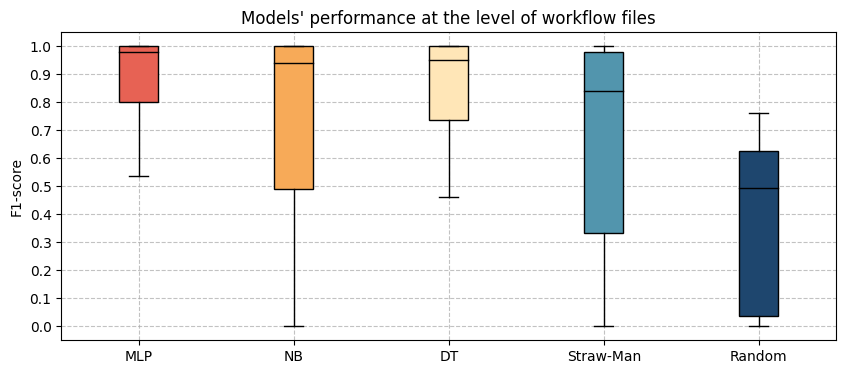

In [26]:
positions = [1, 2, 3, 4, 5]
labels = ['MLP', 'NB', 'DT', 'Straw-Man', 'Random']
#labels = ['All', 'Historical', 'Complexity', 'Churn', 'Straw-Man']
#data_first100 = [f1_grided_first100['all'], f1_grided_first100['his'], f1_grided_first100['com'], f1_grided_first100['chu'], f1_grided_first100['st']]
#data_second100 = [f1_grided_second100['all'], f1_grided_second100['his'], f1_grided_second100['com'], f1_grided_second100['chu'], f1_grided_second100['st']]
data_models_f1 = [f1_grided_first100['all'],f1_grided_first100['gnb'],f1_grided_first100['dt'],f1_grided_first100['st'],f1_grided_first100['rg']]
data_models_precision = [precision_grided_first100['all'],precision_grided_first100['gnb'],precision_grided_first100['dt'],precision_grided_first100['st'],precision_grided_first100['rg']]
data_models_recall = [recall_grided_first100['all'],recall_grided_first100['gnb'],recall_grided_first100['dt'],recall_grided_first100['st'],recall_grided_first100['rg']]
medianprops = dict(linestyle='-', linewidth=1, color='black')


fig, ax = plt.subplots(figsize=(10, 4))

box = ax.boxplot(data_models_f1, vert=True, patch_artist=True, showfliers=False, medianprops=medianprops, widths=0.25)
# Change the color of the body of the boxes
colors = [
    (231/255, 98/255, 84/255),
    #(239/255, 138/255, 71/255),
    (247/255, 170/255, 88/255),
    #(255/255, 208/255, 111/255),
    (255/255, 230/255, 183/255),
    #(170/255, 220/255, 224/255),
    #(114/255, 188/255, 213/255),
    (82/255, 149/255, 173/255),
    #(55/255, 103/255, 149/255),
    (30/255, 70/255, 110/255)
]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    
ax.set_ylabel('F1-score')
ax.set_yticks([i * 0.1 for i in range(0,11)])
ax.set_xticks(positions, labels)
ax.set_title("Models' performance at the level of workflow files")
ax.grid(True, linestyle='--', alpha=0.7, color = 'darkgray', zorder=0)
'''
box = ax[1].boxplot(data_models_precision, vert=True, patch_artist=True, showfliers=False, medianprops=medianprops, widths=0.25)
# Change the color of the body of the boxes
colors = ['#FFDB58', '#ff6205', 'lightgreen', 'lightpink']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    
ax[1].set_ylabel('F1-score')
ax[1].set_yticks([i * 0.1 for i in range(0,11)])
ax[1].set_xticks(positions, labels)
ax[1].grid(True, linestyle='--', alpha=0.7, color = 'darkgray', zorder=0)

box = ax[2].boxplot(data_models_recall, vert=True, patch_artist=True, showfliers=False, medianprops=medianprops, widths=0.25)
# Change the color of the body of the boxes
colors = ['#FFDB58', '#ff6205', 'lightgreen', 'lightpink']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    
ax[2].set_ylabel('F1-score')
ax[2].set_yticks([i * 0.1 for i in range(0,11)])
ax[2].set_xticks(positions, labels)
ax[2].grid(True, linestyle='--', alpha=0.7, color = 'darkgray', zorder=0)
'''
plt.savefig('../plots/box_plot_models.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [27]:
positions = [1, 2]
colors = [
    #(231/255, 98/255, 84/255),
    #(239/255, 138/255, 71/255),
    #(247/255, 170/255, 88/255),
    (255/255, 208/255, 111/255),
    #(255/255, 230/255, 183/255),
    #(170/255, 220/255, 224/255),
    #(114/255, 188/255, 213/255),
    #(82/255, 149/255, 173/255),
    (55/255, 103/255, 149/255),
    #(30/255, 70/255, 110/255)
]
labels = ['First 100','Second 100']
#data_first100 = [f1_grided_first100['all'], f1_grided_first100['his'], f1_grided_first100['com'], f1_grided_first100['chu'], f1_grided_first100['st']]
#data_second100 = [f1_grided_second100['all'], f1_grided_second100['his'], f1_grided_second100['com'], f1_grided_second100['chu'], f1_grided_second100['st']]
data_all = [f1_grided_first100['all'], f1_grided_second100['all']]
data_his = [f1_grided_first100['his'], f1_grided_second100['his']]
data_com = [f1_grided_first100['com'], f1_grided_second100['com']]
data_chu = [f1_grided_first100['chu'], f1_grided_second100['chu']]
data_st = [f1_grided_first100['st'], f1_grided_second100['st']]
medianprops = dict(linestyle='-', linewidth=1, color='black')

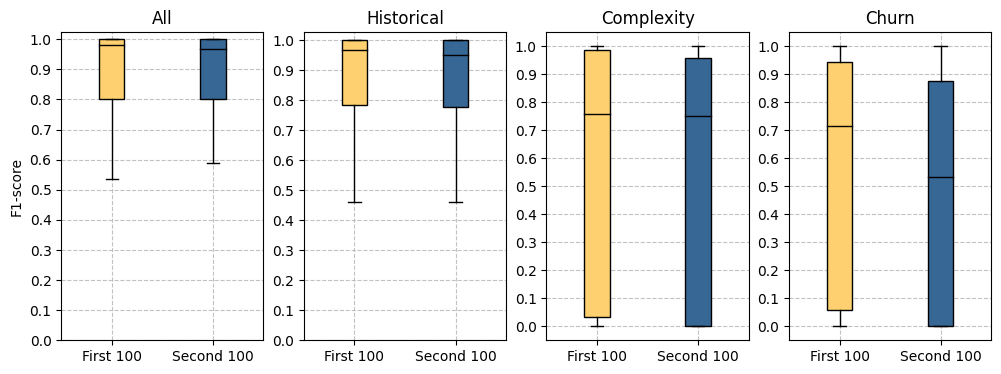

In [28]:
fig, ax = plt.subplots(1, 4, figsize=(12, 4))

box = ax[0].boxplot(data_all, vert=True, patch_artist=True, showfliers=False, medianprops=medianprops, widths=0.25)
# Change the color of the body of the boxes
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    
ax[0].set_ylabel('F1-score')
ax[0].set_yticks([i * 0.1 for i in range(0,11)])
ax[0].set_xticks(positions, labels)
ax[0].set_title('All')
ax[0].grid(True, linestyle='--', alpha=0.7, color = 'darkgray', zorder=0)


box = ax[1].boxplot(data_his, vert=True, patch_artist=True, showfliers=False, medianprops=medianprops, widths=0.25)
# Change the color of the body of the boxes
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    

ax[1].set_yticks([i * 0.1 for i in range(0,11)])
ax[1].set_xticks(positions, labels)
ax[1].set_title('Historical')
ax[1].grid(True, linestyle='--', alpha=0.7, color = 'darkgray', zorder=0)

box = ax[2].boxplot(data_com, vert=True, patch_artist=True, showfliers=False, medianprops=medianprops, widths=0.25)
# Change the color of the body of the boxes
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    

ax[2].set_yticks([i * 0.1 for i in range(0,11)])
ax[2].set_xticks(positions, labels)
ax[2].set_title('Complexity')
ax[2].grid(True, linestyle='--', alpha=0.7, color = 'darkgray', zorder=0)

box = ax[3].boxplot(data_chu, vert=True, patch_artist=True, showfliers=False, medianprops=medianprops, widths=0.25)
# Change the color of the body of the boxes
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    

ax[3].set_yticks([i * 0.1 for i in range(0,11)])
ax[3].set_xticks(positions, labels)
ax[3].set_title('Churn')
ax[3].grid(True, linestyle='--', alpha=0.7, color = 'darkgray', zorder=0)

'''
box = ax[4].boxplot(data_st, vert=True, patch_artist=True, medianprops=medianprops, widths=0.25)
# Change the color of the body of the boxes
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    

ax[4].set_yticks([i * 0.1 for i in range(0,11)])
ax[4].set_xticks(positions, labels)
ax[4].set_title('Straw-Man')
ax[4].grid(True, linestyle='--', alpha=0.7, color = 'darkgray', zorder=0)
'''

plt.savefig('../plots/box_plot.pdf', format='pdf', bbox_inches='tight')
plt.show()